In [1]:
!pip install opendatasets
!pip install librosa
!pip install seaborn
!pip install scikit-learn
!pip install torch torchvision torchaudio --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 108.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 81.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 55.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 87.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

In [2]:
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import librosa
import librosa.display
from IPython.display import Audio, display

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

In [3]:
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 5)

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", device)

Device: cuda


In [5]:
import opendatasets as od

dataset_url = "https://www.kaggle.com/datasets/dmitrybabko/speech-emotion-recognition-en"
od.download(dataset_url)
data_dir = "./speech-emotion-recognition-en"

In [6]:
Ravdess = os.path.join(data_dir, "Ravdess", "audio_speech_actors_01-24")
Crema   = os.path.join(data_dir, "Crema")
Tess    = os.path.join(data_dir, "Tess")
Savee   = os.path.join(data_dir, "Savee")

In [7]:
def ravdess_emotion_extractor(filename):
    filename = filename.replace('.wav', '')
    emotion_code = int(filename.split('-')[2])
    return {1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}[emotion_code]

def crema_emotion_extractor(filename):
    filename = filename.replace('.wav', '')
    part = filename.split('_')[2]
    return {'SAD': 'sad', 'ANG': 'angry', 'DIS': 'disgust',
            'FEA': 'fear', 'HAP': 'happy', 'NEU': 'neutral'}.get(part, 'Unknown')

def tess_emotion_extractor(filename):
    filename = filename.replace('.wav', '')
    part = filename.split('_')[2]
    return 'surprise' if part == 'ps' else part

def savee_emotion_extractor(filename):
    filename = filename.replace('.wav', '')
    parts = filename.split('_')
    if len(parts) < 2:
        return 'Unknown'

    try:
        code_part = parts[1]
        ele = ''
        for char in code_part:
            if char.isdigit():
                break
            else:
                ele += char

        mapping = {
            'a': 'angry',
            'd': 'disgust',
            'f': 'fear',
            'h': 'happy',
            'n': 'neutral',
            'sa': 'sad',
            'su': 'surprise'
        }
        return mapping.get(ele, 'Unknown')
    except Exception as e:
        print(f"Error processing filename {filename}: {e}")
        return 'Unknown'

In [8]:
def get_emotion_and_path(dataset_dir, emotion_extractor):
    """
    Loop through dataset_dir. If a directory is encountered, loop over its files.
    Returns a DataFrame with two columns: Emotions and Path.
    """
    file_emotion, file_path = [], []
    for item in os.listdir(dataset_dir):
        full_item = os.path.join(dataset_dir, item)
        if os.path.isdir(full_item):
            # If folder then list files inside it.
            for file in os.listdir(full_item):
                file_emotion.append(emotion_extractor(file))
                file_path.append(os.path.join(full_item, file))
        else:
            file_emotion.append(emotion_extractor(item))
            file_path.append(full_item)
    return pd.DataFrame({'Emotions': file_emotion, 'Path': file_path})

In [9]:
Ravdess_df = get_emotion_and_path(Ravdess, ravdess_emotion_extractor)
Crema_df   = get_emotion_and_path(Crema, crema_emotion_extractor)
Tess_df    = get_emotion_and_path(Tess, tess_emotion_extractor)
Savee_df   = get_emotion_and_path(Savee, savee_emotion_extractor)

In [10]:
data_path = pd.concat([Ravdess_df, Crema_df, Tess_df, Savee_df], axis=0, ignore_index=True)
data_path['Emotions'] = data_path['Emotions'].str.replace('.wav', '', regex=False)

data_path.to_csv("data_path.csv", index=False)

<ipython-input-11-b0351486b609>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Emotions', data=data_path,


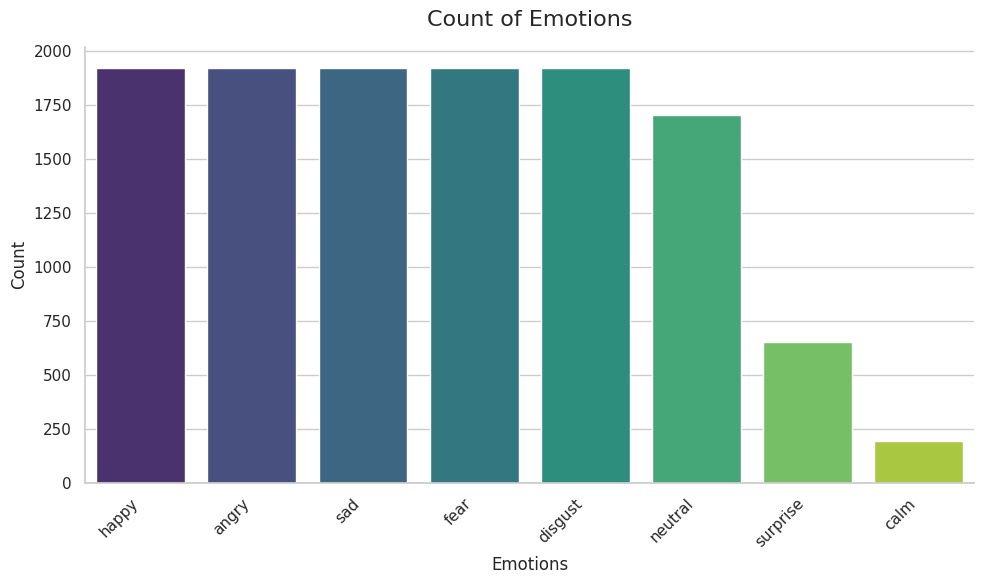

In [11]:
plt.figure(figsize=(10, 6))
sns.countplot(x='Emotions', data=data_path,
              order=data_path['Emotions'].value_counts().index,
              palette='viridis')
plt.title('Count of Emotions', fontsize=16, pad=15)
plt.xlabel('Emotions', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45, ha='right')
sns.despine(top=True, right=True)
plt.tight_layout()
plt.show()

In [12]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title(f'Waveplot for audio with {e} emotion', size=15)
    librosa.display.waveshow(data, sr=sr)
    plt.show()

def create_spectrogram(data, sr, e):
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title(f'Spectrogram for audio with {e} emotion', size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
    plt.colorbar()

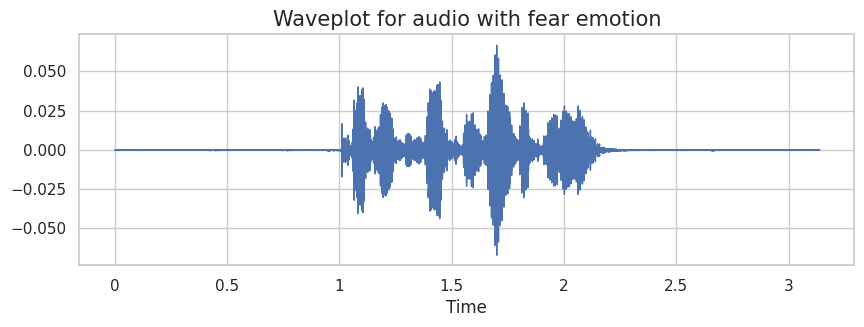

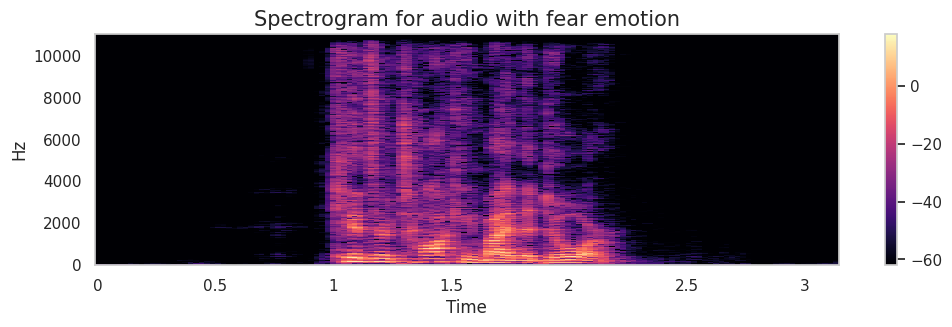

In [13]:
emotion = 'fear'
path = np.array(data_path.Path[data_path.Emotions == emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

In [14]:
SR = 22050
N_MFCC = 40
MAX_PAD_LEN = 174

In [15]:
def extract_features(file_path, sr=SR, n_mfcc=N_MFCC, max_pad_len=MAX_PAD_LEN):
    try:
        audio, sample_rate = librosa.load(file_path, sr=sr)
        mfcc = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=n_mfcc)

        if mfcc.shape[1] < max_pad_len:
            pad_width = max_pad_len - mfcc.shape[1]
            mfcc = np.pad(mfcc, pad_width=((0,0),(0,pad_width)), mode='constant')

        else:
            mfcc = mfcc[:, :max_pad_len]
        return mfcc

    except Exception as e:
        print("Error in", file_path, ":", e)
        return None

In [16]:
features = []
labels = []
for idx, row in data_path.iterrows():
    mfcc = extract_features(row['Path'])
    if mfcc is not None:
        features.append(mfcc)
        labels.append(row['Emotions'])

features = np.array(features)
print("Features shape:", features.shape)

Features shape: (12162, 40, 174)


In [17]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(features, labels_encoded,
                                                    test_size=0.2,
                                                    stratify=labels_encoded,
                                                    random_state=42)
print("Training samples:", X_train.shape[0])
print("Testing samples :", X_test.shape[0])


Training samples: 9729
Testing samples : 2433


In [18]:
class SpeechEmotionDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels
    def __len__(self):
        return len(self.features)
    def __getitem__(self, idx):
        X = self.features[idx].astype(np.float32)
        y = self.labels[idx]
        return torch.tensor(X), torch.tensor(y, dtype=torch.long)

In [19]:
BATCH_SIZE = 32
train_dataset = SpeechEmotionDataset(X_train, y_train)
test_dataset = SpeechEmotionDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [26]:
class CRNN(nn.Module):
    def __init__(self, num_classes):
        super(CRNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv1d(in_channels=N_MFCC, out_channels=128, kernel_size=5, padding=2),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.MaxPool1d(2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv1d(128, 256, kernel_size=5, padding=2),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.MaxPool1d(2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv1d(256, 512, kernel_size=5, padding=2),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.MaxPool1d(2)
        )
        self.rnn = nn.GRU(input_size=512, hidden_size=128, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(128 * 2, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.permute(0, 2, 1)
        out, _ = self.rnn(x)
        out = torch.mean(out, dim=1)
        out = self.dropout(out)
        out = self.fc(out)
        return out


num_classes = len(np.unique(y_train))
model = CRNN(num_classes=num_classes).to(device)
print(model)

CRNN(
  (conv1): Sequential(
    (0): Conv1d(40, 128, kernel_size=(5,), stride=(1,), padding=(2,))
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv1d(128, 256, kernel_size=(5,), stride=(1,), padding=(2,))
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv1d(256, 512, kernel_size=(5,), stride=(1,), padding=(2,))
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (rnn): GRU(512, 128, batch_first=True, bidirectional=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=

In [27]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
num_epochs = 50

In [28]:
train_accuracies = []
test_accuracies = []

best_test_acc = 0.0
patience = 5
wait = 0
best_model_state = None

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

def evaluate_model(model, loader, device):
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    accuracy = correct / total
    return accuracy, all_preds, all_labels

print("Training starts here:")
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    start_time = time.time()

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (preds == labels).sum().item()

    scheduler.step()

    train_acc = correct / total
    train_accuracies.append(train_acc)

    test_acc, y_pred, y_true = evaluate_model(model, test_loader, device)
    test_accuracies.append(test_acc)

    epoch_loss = running_loss / total
    elapsed = time.time() - start_time

    print(f"Epoch {epoch+1}/{num_epochs}: Loss={epoch_loss:.4f}, Train Acc={train_acc:.4f}, Test Acc={test_acc:.4f}, Time={elapsed:.2f}s")

    if test_acc > best_test_acc:
        best_test_acc = test_acc
        wait = 0
        best_model_state = model.state_dict()
    else:
        wait += 1
        if wait >= patience:
            print(f"Stopping early at epoch {epoch+1} — no improvement in {patience} epochs.")
            break

if best_model_state:
    model.load_state_dict(best_model_state)
    print(f"Loaded best model with Test Acc: {best_test_acc:.4f}")

Training starts here:
Epoch 1/50: Loss=1.3173, Train Acc=0.5039, Test Acc=0.5631, Time=2.78s
Epoch 2/50: Loss=1.0426, Train Acc=0.6086, Test Acc=0.6210, Time=2.26s
Epoch 3/50: Loss=0.9401, Train Acc=0.6461, Test Acc=0.6132, Time=2.28s
Epoch 4/50: Loss=0.8807, Train Acc=0.6706, Test Acc=0.6145, Time=2.30s
Epoch 5/50: Loss=0.7883, Train Acc=0.7097, Test Acc=0.6905, Time=2.30s
Epoch 6/50: Loss=0.7273, Train Acc=0.7307, Test Acc=0.6621, Time=2.63s
Epoch 7/50: Loss=0.6621, Train Acc=0.7555, Test Acc=0.6979, Time=2.28s
Epoch 8/50: Loss=0.6275, Train Acc=0.7695, Test Acc=0.7024, Time=2.29s
Epoch 9/50: Loss=0.5558, Train Acc=0.8002, Test Acc=0.7143, Time=2.30s
Epoch 10/50: Loss=0.5117, Train Acc=0.8134, Test Acc=0.7156, Time=2.29s
Epoch 11/50: Loss=0.3738, Train Acc=0.8721, Test Acc=0.7283, Time=2.70s
Epoch 12/50: Loss=0.3231, Train Acc=0.8916, Test Acc=0.7472, Time=2.29s
Epoch 13/50: Loss=0.3016, Train Acc=0.8947, Test Acc=0.7320, Time=2.29s
Epoch 14/50: Loss=0.2704, Train Acc=0.9116, Test Ac

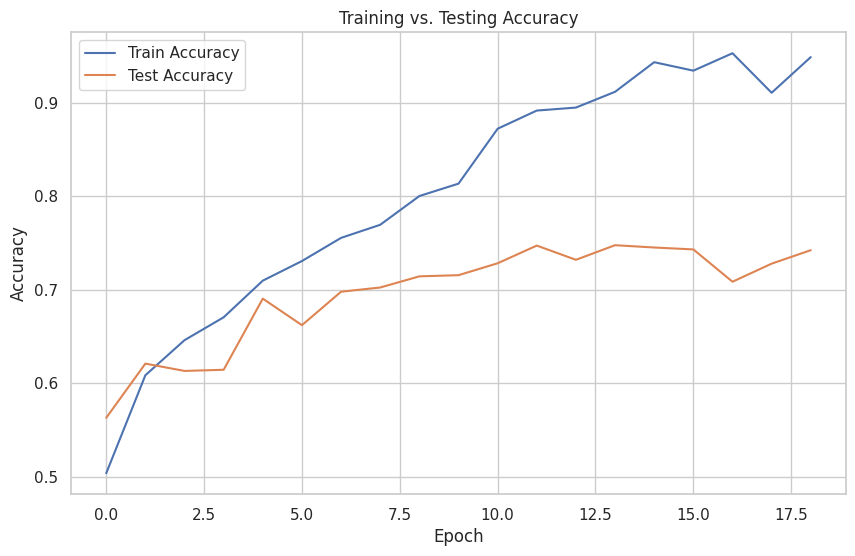

In [29]:
plt.figure(figsize=(10,6))
plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(test_accuracies, label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training vs. Testing Accuracy")
plt.legend()
plt.grid(True)
plt.show()

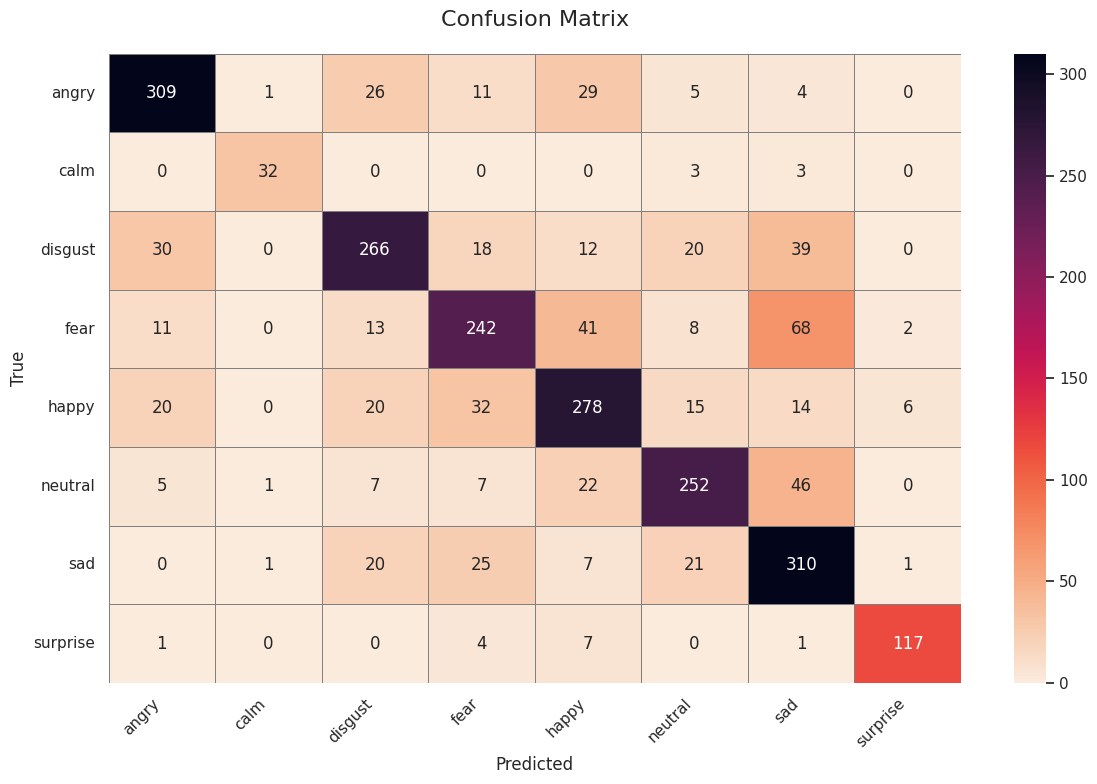

In [30]:
cm = confusion_matrix(y_true, y_pred)
classes = [lbl.replace('.wav', '') for lbl in label_encoder.inverse_transform(np.arange(num_classes))]

plt.figure(figsize=(12,8))
custom_cmap = sns.cm.rocket_r
sns.heatmap(cm, annot=True, fmt='d', cmap=custom_cmap,
            xticklabels=classes, yticklabels=classes,
            linewidths=0.5, linecolor='gray')
plt.title("Confusion Matrix", fontsize=16, pad=20)
plt.xlabel("Predicted", fontsize=12)
plt.ylabel("True", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()